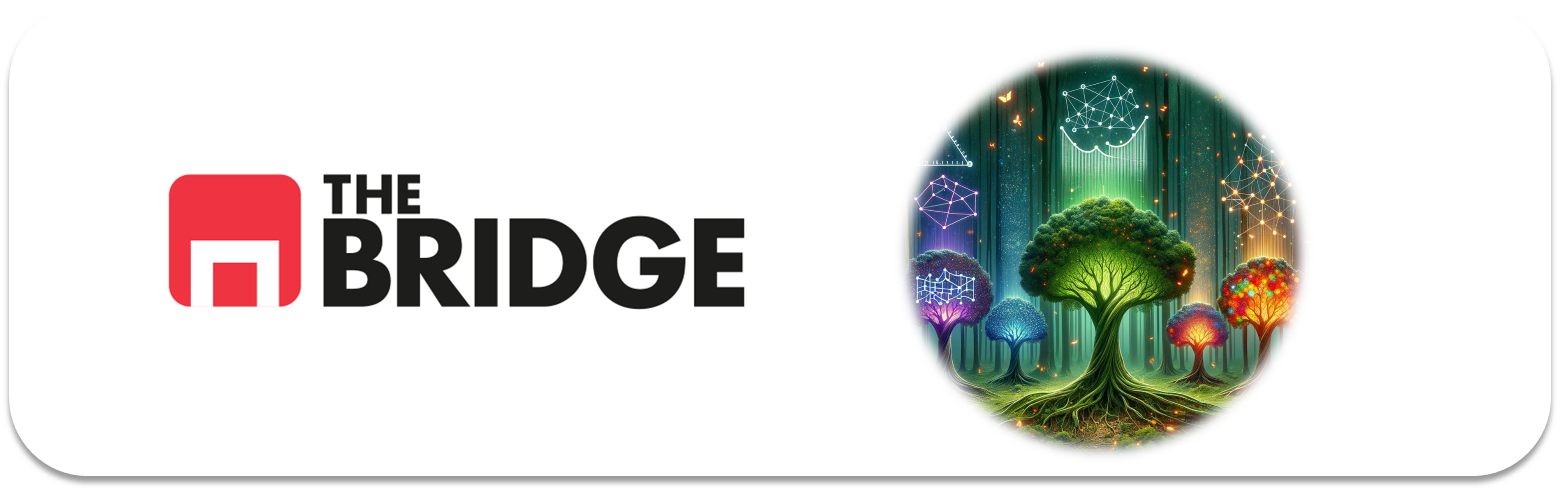

## PRACTICA OBLIGATORIA: **Ensamblado de modelos, bagging, boosting, random forest y gbts**

* La práctica obligatoria de esta unidad consiste en un único ejercicio de obtención del mejor modelo para la resolución de un problema de clasificación sobre diabetes en la india. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import bootcampviztools as viz

import numpy as np
import pandas as pd
import seaborn as sns

from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from xgboost import XGBClassifier

### Descripción del dataset

El dataset de los Pima Indians Diabetes contiene datos de un grupo de mujeres de al menos 21 años de edad de ascendencia india Pima que viven cerca de Phoenix, Arizona, EE. UU. Las características del dataset incluyen varios predictores médicos y un objetivo que indica si la paciente desarrolló diabetes dentro de cinco años.

### Características del Dataset

Las variables incluidas en el dataset son:

1. **Número de Embarazos**: Cantidad de veces embarazada.
2. **Concentración de Glucosa en Plasma**: Concentración de glucosa en plasma a 2 horas en una prueba de tolerancia oral a la glucosa.
3. **Presión Arterial Diastólica**: Presión arterial diastólica (mm Hg).
4. **Grosor del Pliegue Cutáneo del Tríceps**: Grosor del pliegue cutáneo del tríceps (mm).
5. **Insulina en Suero**: Insulina en suero a 2 horas (mu U/ml).
6. **Índice de Masa Corporal**: Peso en kg/(altura en m)^2.
7. **Función del Pedigree de Diabetes**: Una función que representa la predisposición genética a la diabetes.
8. **Edad**: Edad en años.
9. **Variable Objetivo**: Indica si la paciente desarrolló diabetes (1) o no (0).

### Carga de datos

El dataset lo puedes encontrar en la siguiente url y a continuación se proporciona una lista de nombres sugeridos para las columnas:


In [2]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"

names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']

### Enunciado

Construye el mejor modelo que puedas para predecir a partir de los datos de entrada si una mujer de la tribu Pima desarrollará diabetes. Para ello obtén al menos tres modelos a partir de tecnologías de bagging y boosting (al menos uno de cada), compáralos sin utilizar el test y selecciona uno de ellos como el mejor (justificándolo). Termina el ejercicio probando el modelo seleccionado y con sus hiperparámetros optimizados contra un dataset de test que deberás haber reservado con anterioridad.

# 1. Carga de datos y clasificación de variables

In [3]:
df = pd.read_csv(url,names=names)
df.head()

,preg,plas,pres,skin,test,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   preg    768 non-null    int64  
 1   plas    768 non-null    int64  
 2   pres    768 non-null    int64  
 3   skin    768 non-null    int64  
 4   test    768 non-null    int64  
 5   mass    768 non-null    float64
 6   pedi    768 non-null    float64
 7   age     768 non-null    int64  
 8   class   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


No hay nulos. Realizamos la clasificación de variables

In [5]:
#Creamos una función para clasificar las variables
def tipifica_variables(df, umbral_categoria, umbral_continua):

    #Creamos una lista con el tipo de cada variable
    lista_tipos = []
        
    #Creamos una lista con la tipificación sugerida para cada variable
    lista_tipificacion = []

    #Creamos dos listas para guardar la cardinalidad de cada variable
    lista_cardinalidad = []
    lista_cardinalidad_porcentaje = []

    #Sugerimos la tipificación de la variable y la guardamos en la lista
    for columna in df.columns:
            
        #Guardamos en la lista el tipo de cada variable
        lista_tipos.append(df[columna].dtypes)
            
        #Calculamos la cardinalidad y la guardamos en las listas
        cardinalidad = df[columna].nunique()
        lista_cardinalidad.append(cardinalidad)
        
        cardinalidad_porcentaje = round(cardinalidad/len(df)*100,2)
        lista_cardinalidad_porcentaje.append(cardinalidad_porcentaje)

        #Clasificamos segun el valor de la cardinalidad
        if cardinalidad == 2:
            lista_tipificacion.append("Binaria")
                
        elif cardinalidad >= umbral_categoria:
                
            if cardinalidad >= umbral_continua:
                lista_tipificacion.append("Numérica continua")
                    
            else: 
                lista_tipificacion.append("Numérica discreta")

        else:
            lista_tipificacion.append("Categórica")

        
    #Creamos el DataFrame con tantas filas como columnas tenga el DataFrame
    df_tipifica = pd.DataFrame({"nombre_variable": df.columns.tolist(), "tipo_variable":lista_tipos, "cardinalidad":lista_cardinalidad, "cardinalidad_porcentaje":lista_cardinalidad_porcentaje , "tipo_sugerido":lista_tipificacion})
    
    return df_tipifica

In [6]:
tipifica_variables(df,umbral_categoria=10,umbral_continua=20)

,nombre_variable,tipo_variable,cardinalidad,cardinalidad_porcentaje,tipo_sugerido
0,preg,int64,17,2.21,Numérica discreta
1,plas,int64,136,17.71,Numérica continua
2,pres,int64,47,6.12,Numérica continua
3,skin,int64,51,6.64,Numérica continua
4,test,int64,186,24.22,Numérica continua
5,mass,float64,248,32.29,Numérica continua
6,pedi,float64,517,67.32,Numérica continua
7,age,int64,52,6.77,Numérica continua
8,class,int64,2,0.26,Binaria


Clasificamos las variables:
* preg: Cantidad de veces embarazada. Tipo: Numérica discreta
* plas: Concentración de glucosa en plasma a 2 horas en una prueba de tolerancia oral a la glucosa. Tipo: Numérica continua
* pres: Presión arterial diastólica (mm Hg). Tipo: Numérica continua
* skin: Grosor del pliegue cutáneo del tríceps (mm). Tipo: Numérica continua
* test: Insulina en suero a 2 horas (mu U/ml). Tipo: Numérica continua
* mass: Peso en kg/(altura en m)^2. Tipo: Numérica continua
* pedi: Una función que representa la predisposición genética a la diabetes. Tipo: Numérica continua
* age: Edad en años. Tipo: Numérica continua
* class: Indica si la paciente desarrolló diabetes (1) o no (0). Categórica (binaria)


# 2. Elección del *target*, elección del modelo y separación en train y test

La variable *target* será "class". Revisamos su distribución

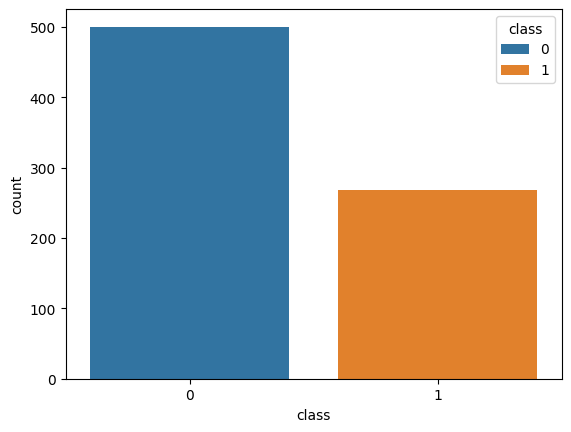

In [7]:
target = "class"
sns.countplot(df, x = target, hue = target);

In [8]:
df["class"].value_counts()

class
0    500
1    268
Name: count, dtype: int64

In [9]:
df["class"].value_counts(normalize=True)

class
0    0.651042
1    0.348958
Name: proportion, dtype: float64

Obtenemos que el dataset está desbalanceado, pero no mucho. Para ésta práctica emplearemos los modelos RandomForest, XGBoost y LightGBM

Realizamos la división del DataFrame en train y test con la relación 80/20

In [10]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

# 3. Proceso EDA

## 3.1. Variables categóricas

No hay variables categóricas para poder seleccionar como *features* (la única variable que existe es el propio *target*)

## 3.2. Variables Numéricas

Realizamos el análisis univariante de las variables numéricas

In [11]:
columnas_numericas = [columna for columna in df.columns if columna !=target]
columnas_numericas

['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age']

In [12]:
train_set.describe()[columnas_numericas].T

,count,mean,std,min,25%,50%,75%,max
preg,614.0,3.742671,3.313264,0.000,1.0000,3.0000,6.00000,17.00
plas,614.0,120.855049,32.035057,0.000,100.0000,117.0000,139.00000,199.00
pres,614.0,69.415309,18.512599,0.000,64.0000,72.0000,80.00000,122.00
skin,614.0,20.399023,15.433974,0.000,0.0000,23.0000,32.00000,63.00
test,614.0,81.438111,116.234835,0.000,0.0000,42.5000,129.75000,846.00
mass,614.0,31.983388,7.740625,0.000,27.1000,32.0000,36.37500,67.10
pedi,614.0,0.469168,0.336847,0.078,0.2415,0.3725,0.61375,2.42
age,614.0,32.907166,11.503437,21.000,24.0000,29.0000,40.00000,81.00


(8, 2)


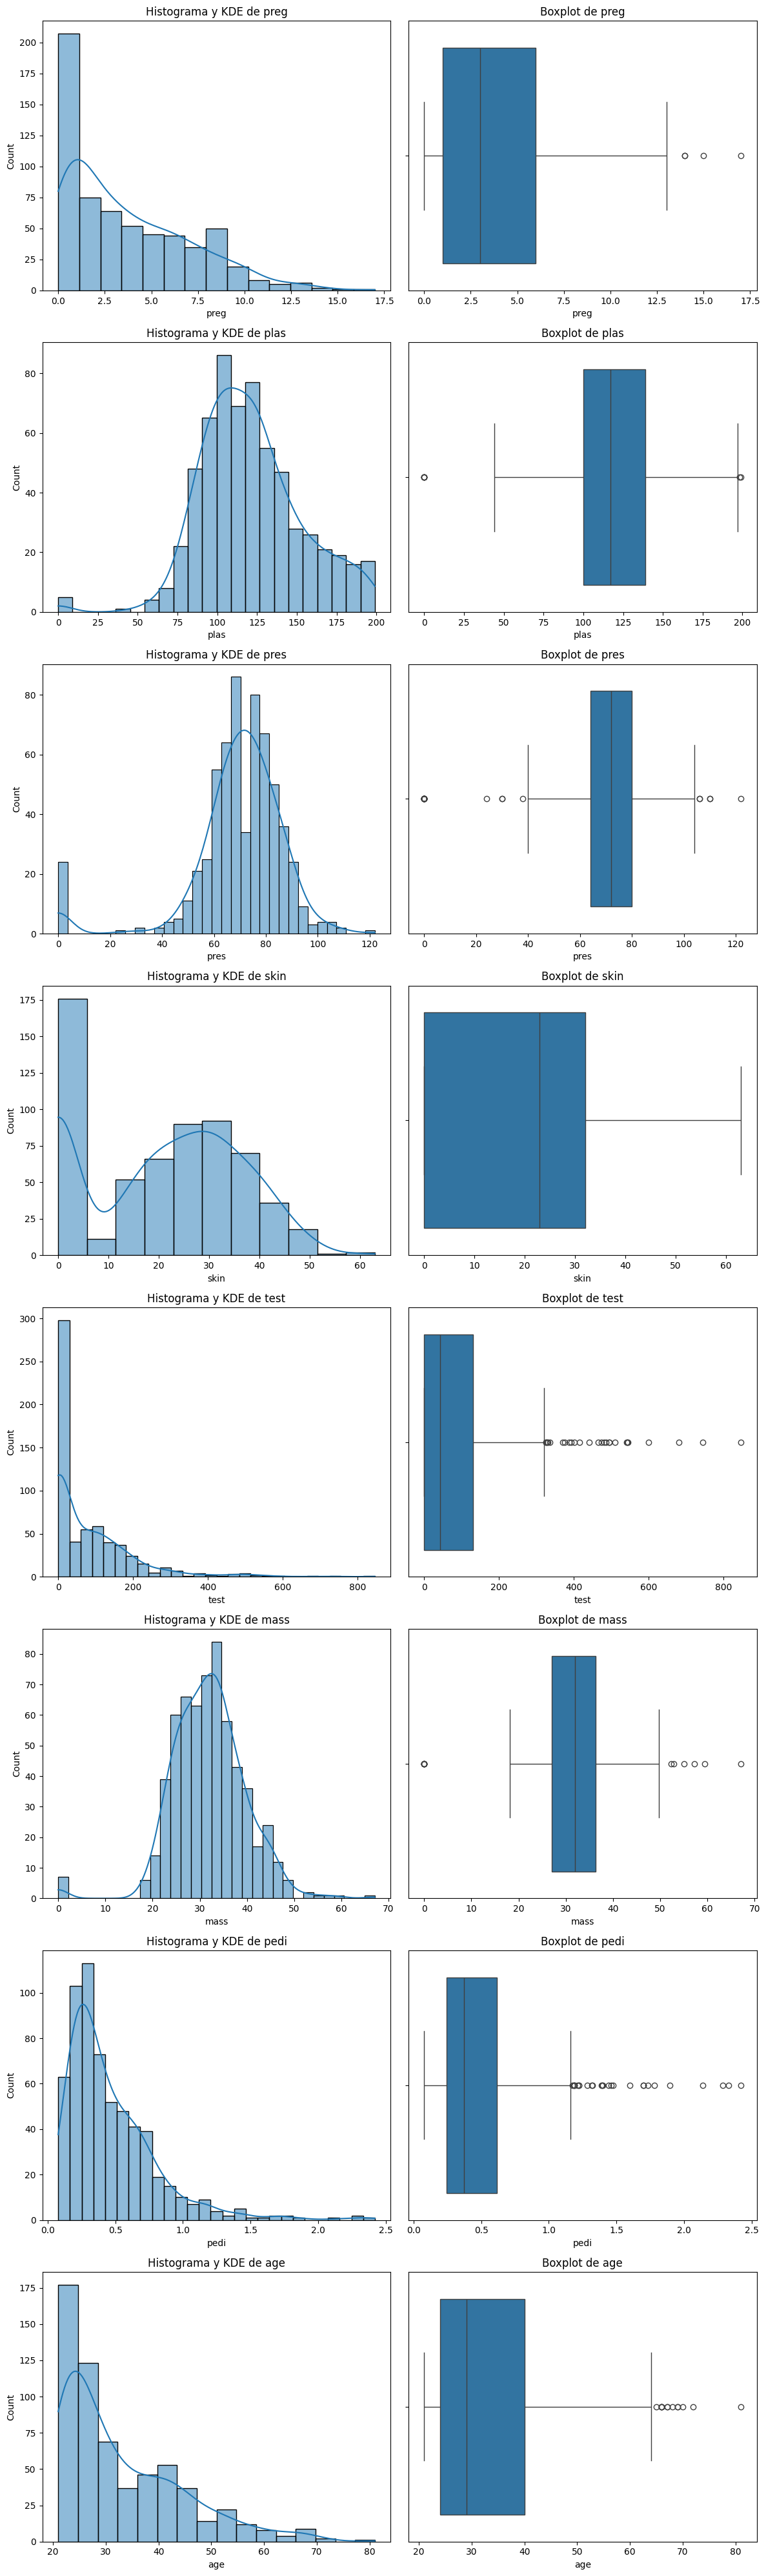

In [13]:
viz.plot_combined_graphs(train_set, columns=columnas_numericas)

Comentarios:
* La variables "plas", "pres", "skin" y "mass" tienen muchos valores a 0 que representan que se desconoce el valor de esa variable

Realizamos el análisis bivariante de las variables numéricas con el *target*

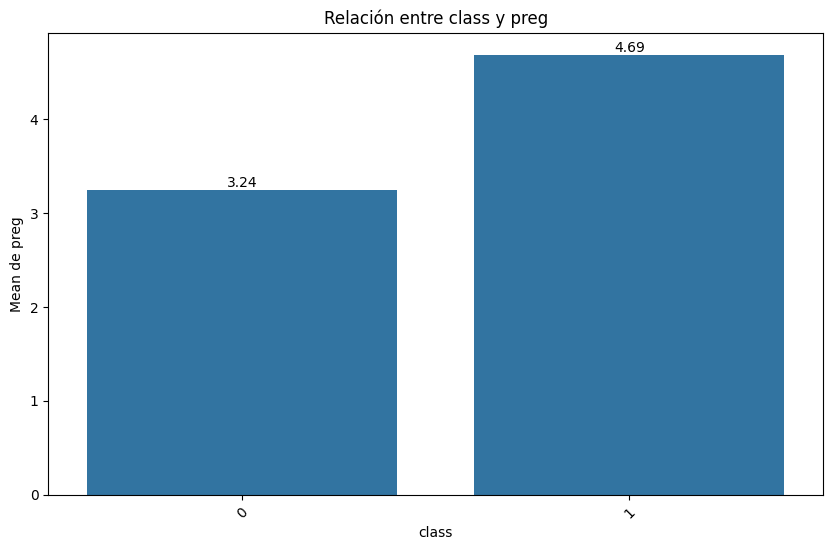

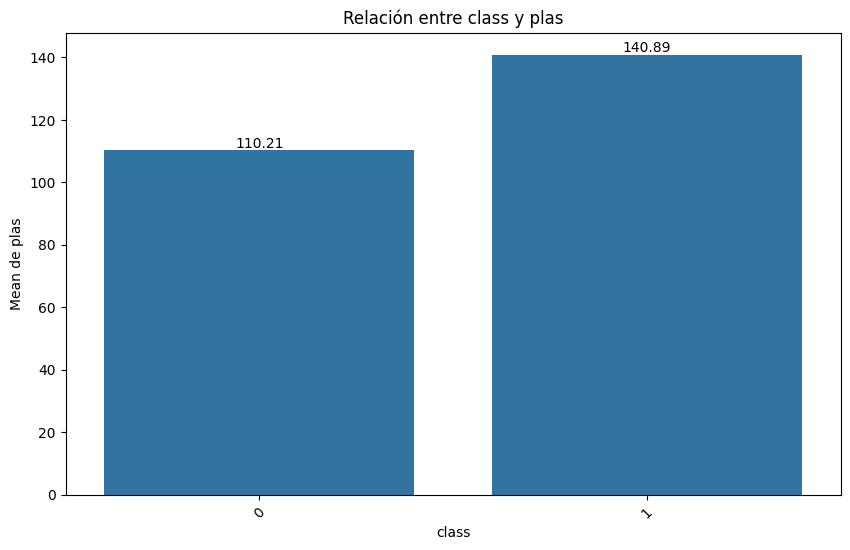

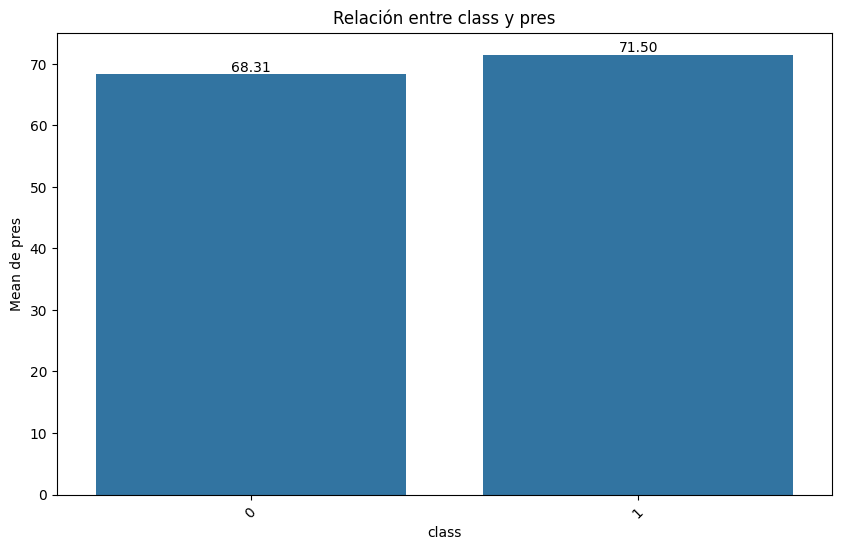

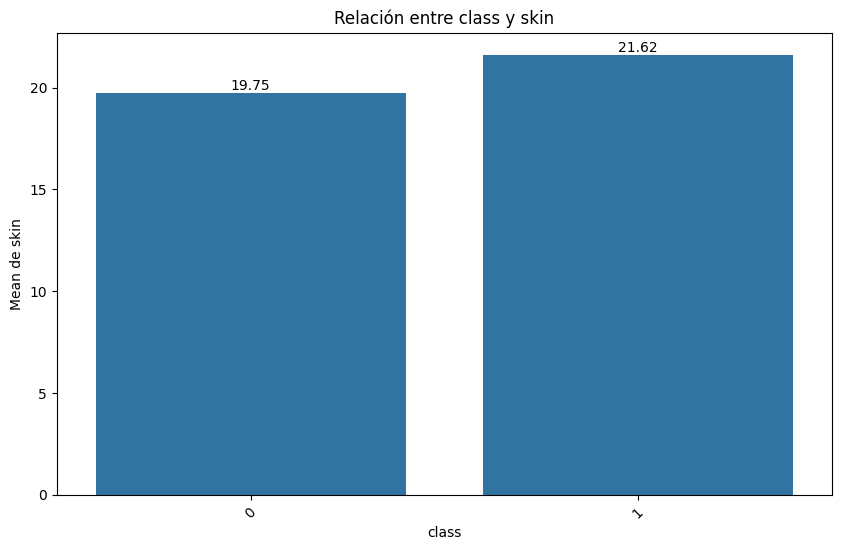

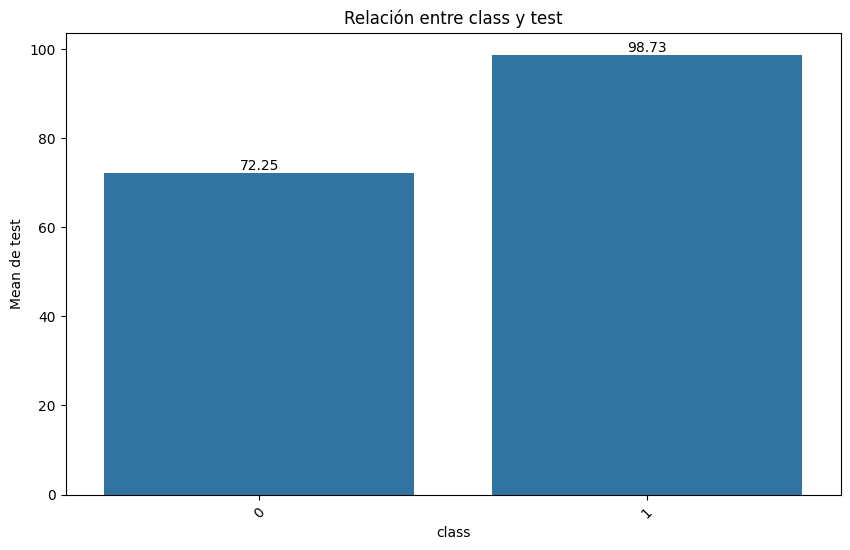

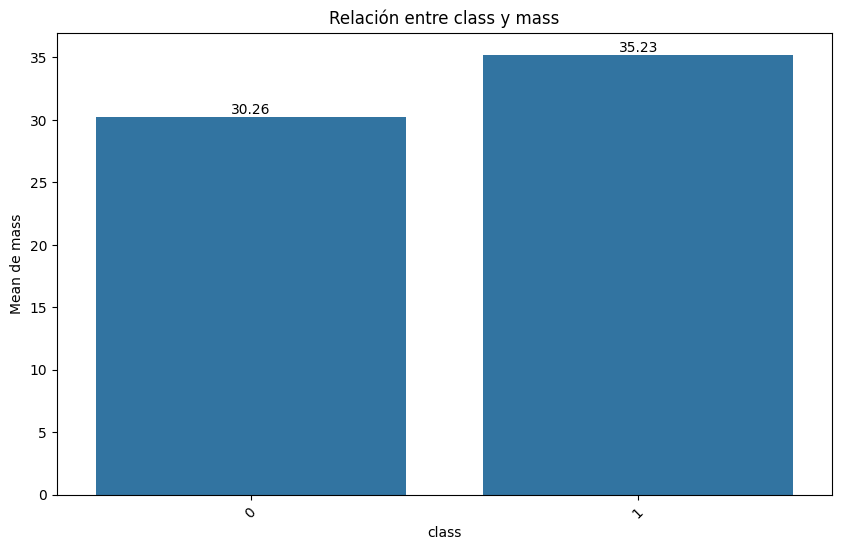

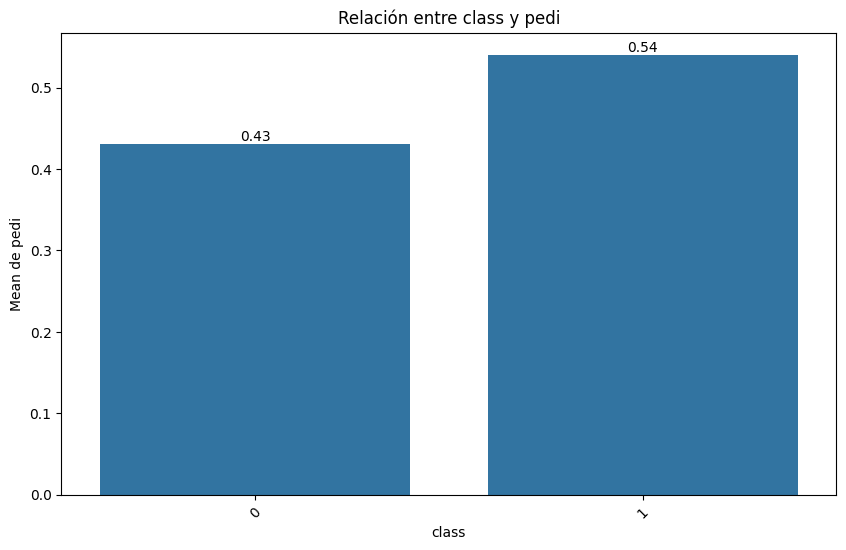

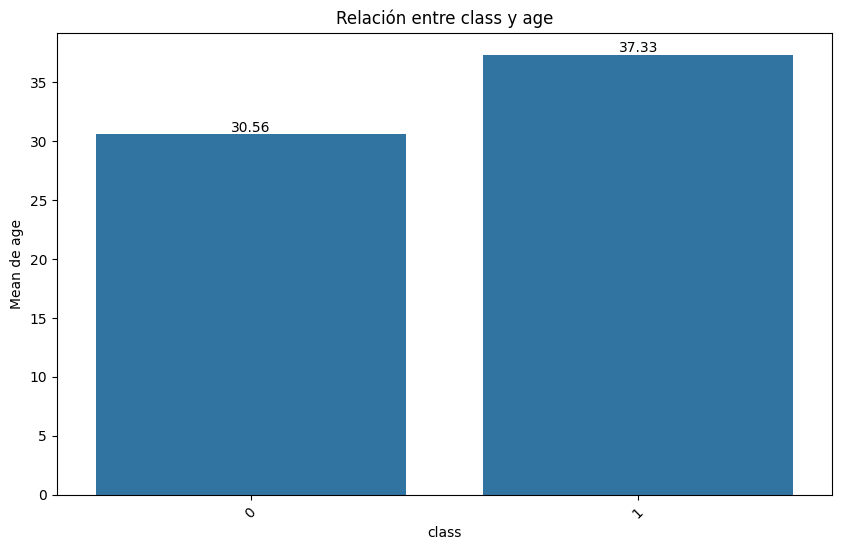

In [14]:
for columna_numerica in columnas_numericas:
    viz.plot_categorical_numerical_relationship(train_set, categorical_col=target, numerical_col=columna_numerica, show_values=True, measure="mean")

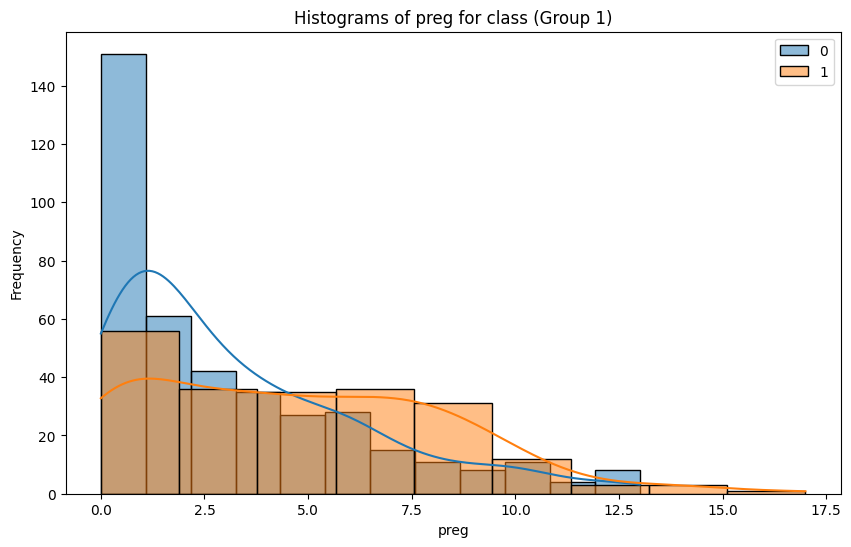

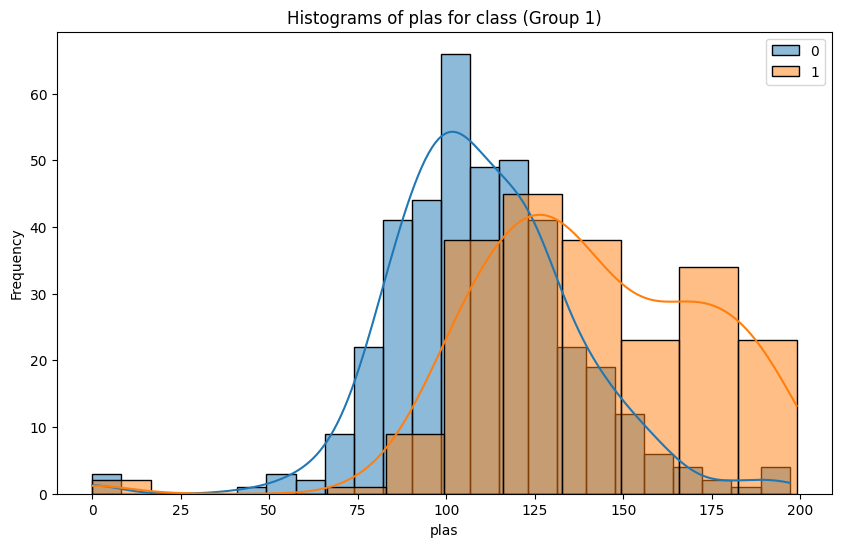

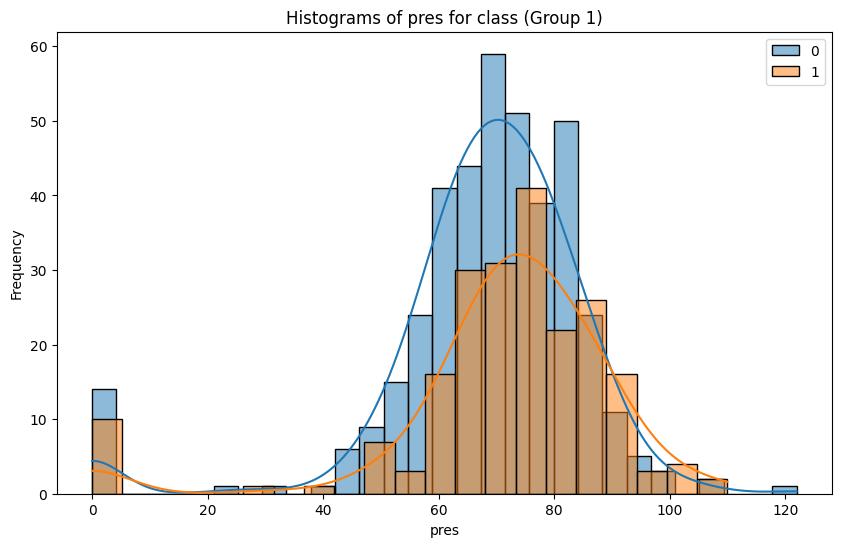

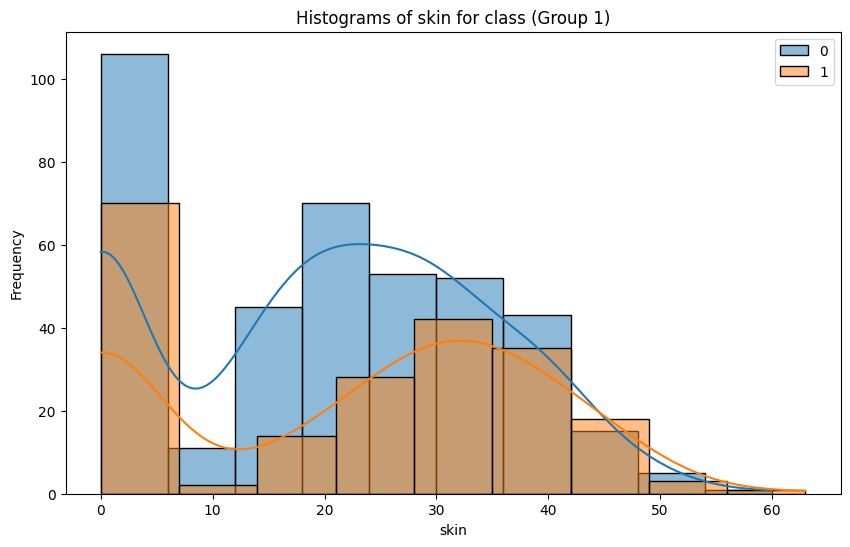

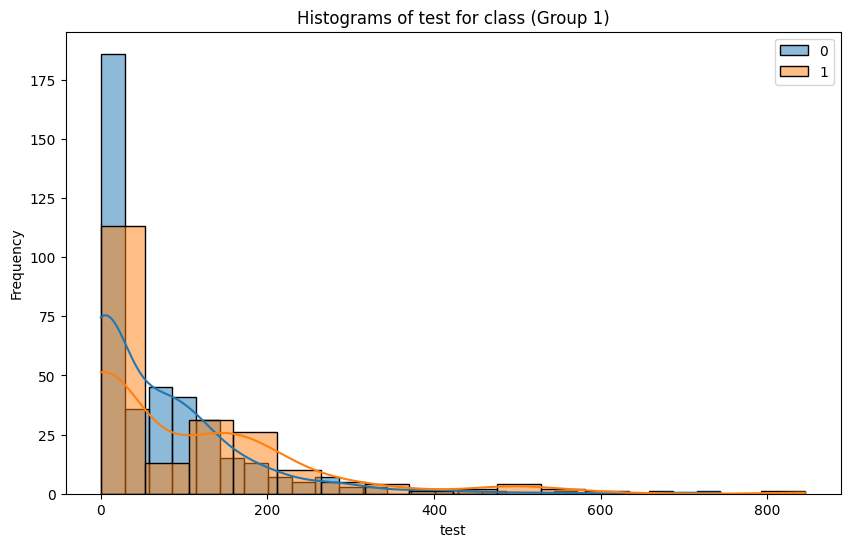

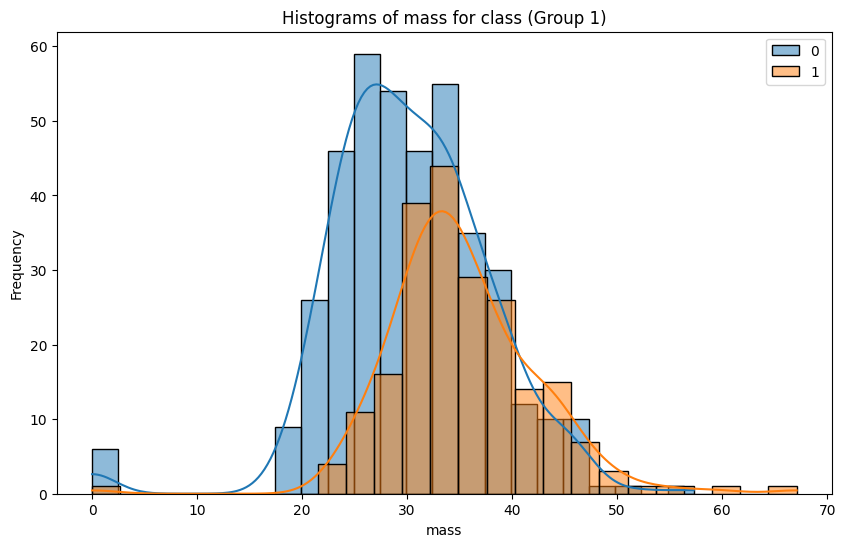

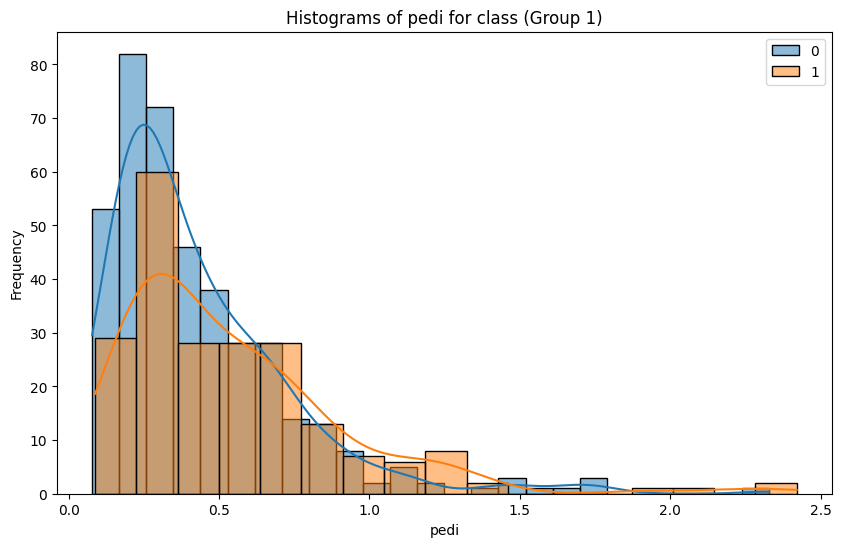

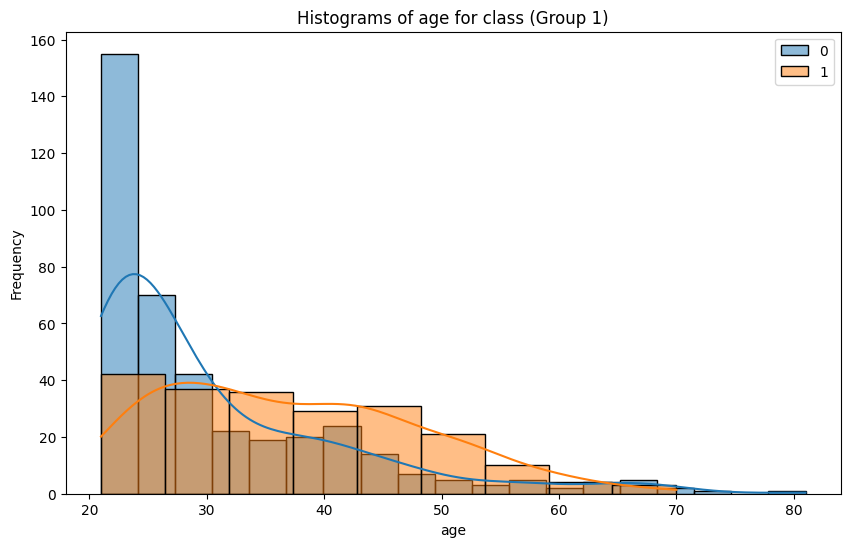

In [15]:
for columna_numerica in columnas_numericas:
    viz.plot_grouped_histograms(train_set, cat_col=target, num_col=columna_numerica, group_size=2)

Comentarios:
* Las variables "preg", "plas" y "age" son las que mejor poder predictor tienen dadas sus distribuciones para los dos valores del *target*
* El resto de variables "pres", "skin", "test", "mass" y "pedi" tienen distribuciones bastante superpuestas aunque con algunas zonas interesantes

Nos quedamos con todas las variables como *features* numéricas

In [16]:
features_num = columnas_numericas
features_num

['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age']

**COMENTARIO**: Si siguieramos un proceso riguroso, las relaciones de las variables con el *target* se deben confirmar mediante los correspondientes tests. En este caso, y por simplicidad ya que no es el objetivo principal del bloque, no se realizan

# 4. Tratamiento de *features*

Todas las *features* son numéricas y para los modelos que vamos a emplear no es neceario realizar el escalado

# 5. Selección del modelo RandomForest, XGBoost o LightGBM

In [17]:
X_train = train_set.drop(columns=target)
y_train = train_set[target]

X_test = test_set.drop(columns=target)
y_test = test_set[target]

Creamos los modelos con los hiperparámetros de ajuste por defecto y los entrenamos

In [18]:
rf_clf = RandomForestClassifier(random_state= 42)
rf_clf.fit(X_train, y_train)

xgb_clf = XGBClassifier(random_state = 42)
xgb_clf.fit(X_train, y_train)

lgb_clf = LGBMClassifier(random_state = 42, verbose = -100)
lgb_clf.fit(X_train, y_train)

LGBMClassifier(random_state=42, verbose=-100)

Creamos una función que nos muestre el clasification report y evaluamos los errores contra train

In [19]:
def clasification_report(model, X, y):
    
    y_pred = model.predict(X)
    
    report = classification_report(y, y_pred)
    print(report)

In [20]:
for nombre, modelo in zip(["RandomForest","XGBoost","LightGBM"],[rf_clf, xgb_clf, lgb_clf]):
    
    print(f"Report para {nombre}:")
    clasification_report(modelo, X_train, y_train)
    
    print("\n")

Report para RandomForest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       401
           1       1.00      1.00      1.00       213

    accuracy                           1.00       614
   macro avg       1.00      1.00      1.00       614
weighted avg       1.00      1.00      1.00       614



Report para XGBoost:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       401
           1       1.00      1.00      1.00       213

    accuracy                           1.00       614
   macro avg       1.00      1.00      1.00       614
weighted avg       1.00      1.00      1.00       614



Report para LightGBM:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       401
           1       1.00      1.00      1.00       213

    accuracy                           1.00       614
   macro avg       1.00      1.00      1.00       614
w

Como era de esperar para estos modelos, todos han realizado *overfitting* al no haber indicado ningún hiperparámetro que lo controle. Vamos a realizar la validación cruzada

In [21]:
val_score = {}

for nombre, modelo in zip(["RandomForest","XGBoost","LightGBM"],[rf_clf, xgb_clf, lgb_clf]):
    
    print(f"Score en validación cruzada para {nombre}:")
    
    #Hacemos la validación cruzada y mostramos el resultado
    metricas = cross_val_score(modelo, X_train, y_train, cv = 5, scoring = "accuracy")
    accuracy = np.mean(metricas)
    print(accuracy)
    
    #Guardamos la métrica en el diccionario
    val_score[nombre] = accuracy
    
    print("\n")

#Seleccionamos el modelo con la mejor métrica en validación cruzada
print(f"Modelo escogido en validación cruzada: {list(val_score.keys())[np.argmax(list(val_score.values()))]}")

Score en validación cruzada para RandomForest:
0.7720511795281888


Score en validación cruzada para XGBoost:
0.7329201652672264


Score en validación cruzada para LightGBM:
0.7557110489137678


Modelo escogido en validación cruzada: RandomForest


A la vista de los resultados, nos quedamos con el modelo RandomForest por haber obtenido el mejor *score*, un 77,2%

# 6. Optimización de los hiperparámetros para el modelo RandomForest

Emplearemos *GridSearch* para la obtención de los hiperparámetros que optimizan el modelo. Definimos un *grid* que incluya los hiperparámetros por defecto de RandomForest, para que se tenga en cuenta el modelo evaluado en validación cruzada

In [22]:
grid_rf = {
    "n_estimators": [100, 250, 500], #El modelo tiene 100 por defecto
    "max_depth": [5, 10, 50, None], #El modelo tiene None por defecto
    "min_samples_split": [2, 5, 10], #El modelo tiene 2 por defecto
    "min_samples_leaf": [1, 2, 4], #El modelo tiene 1 por defecto
}

rf_grid = GridSearchCV(rf_clf, param_grid= grid_rf, cv=5, scoring= "accuracy")

rf_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [5, 10, 50, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 250, 500]},
             scoring='accuracy')

Mostramos la mejor combinación de hiperparámetros encontrada y el *score* obtenido con el método *Grid Search*

In [23]:
print(rf_grid.best_params_)

{'max_depth': 50, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 500}


In [24]:
print(rf_grid.best_score_)

0.7866719978675196


Para el *grid* que hemos definido, conseguimos aumentar el *score* de un poco, de 77,2% a un 78,6%

# 7. Evaluación final del modelo RandomForest optimizado

Una vez seleccionado el modelo RandomForest vamos a evaluarlo contra test

In [25]:
clasification_report(rf_grid, X_test, y_test)

              precision    recall  f1-score   support

           0       0.83      0.83      0.83        99
           1       0.69      0.69      0.69        55

    accuracy                           0.78       154
   macro avg       0.76      0.76      0.76       154
weighted avg       0.78      0.78      0.78       154



Obtenemos un *accuracy* de un 78%, y un *recall* medio de un 76%. En general, no son malos números, por lo que nos quedamos con el modelo RandomForest